
Univariate analysis of block design, one condition versus rest, single subject
==============================================================================

Authors: Bertrand Thirion, Elvis Dohmatob , Christophe Pallier, 2015--2017

Modified: Ralf Schmaelzle, 2019

In this tutorial, we compare the fMRI signal during periods of auditory stimulation
versus periods of rest, using a General Linear Model (GLM). We will
use a univariate approach in which independent tests are performed at
each single-voxel.

The dataset comes from experiment conducted at the FIL by Geriant Rees
under the direction of Karl Friston. It is provided by FIL methods
group which develops the SPM software.

According to SPM documentation, 96 acquisitions were made (RT=7s), in
blocks of 6, giving 16 42s blocks. The condition for successive blocks
alternated between rest and auditory stimulation, starting with rest.
Auditory stimulation was bi-syllabic words presented binaurally at a
rate of 60 per minute. The functional data starts at acquisiton 4,
image fM00223_004.

The whole brain BOLD/EPI images were acquired on a modified 2T Siemens
MAGNETOM Vision system. Each acquisition consisted of 64 contiguous
slices (64x64x64 3mm x 3mm x 3mm voxels). Acquisition took 6.05s, with
the scan to scan repeat time (RT) set arbitrarily to 7s.


This analyse described here is performed in the native space, on the
original EPI scans without any spatial or temporal preprocessing.
(More sensitive results would likely be obtained on the corrected,
spatially normalized and smoothed images).


How does this "jupyter-thing" work? 

It is very easy. A notebook basically consists of cells that can be of two main kinds: Code cells and comment cells. The one you are reading is a comment cell, the one-line-cell below ("Import modules") as well, then comes a code cell. The idea behind this is called literate programming, that is the comment-cells explain stuff in natural language, and the code cells exectute some computer code (and can also display output).

How do I get ahead?

To click through cells, you can either click the 'Run' button above, or you can click in to a cell and press (SHIFT + ENTER). Try it now, and then go....

## Import modules

In [1]:
import os, sys, nibabel
!pip install nistats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
import seaborn as sns

from nilearn import plotting, datasets, image     
from nilearn.image import concat_imgs
from nilearn.input_data import NiftiSpheresMasker
from nistats.first_level_model import FirstLevelModel
from nistats.datasets import fetch_spm_auditory
from nistats.reporting import plot_design_matrix
from nilearn.plotting import plot_stat_map, plot_anat, plot_img

from nibabel.affines import apply_affine

/Users/Ralf/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Ralf/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


If you have made it until here, you will see some confusing code about requirements or so that you can safely ignore. Just go ahead by shift-enter-clicking or pressing the run-button

Retrieving the data
-------------------

The next line of code will fetch a whole fMRI dataset from a server into our litte "data-oven" (the Binder platform runs a virtual machine that runs this jupyter notebook).

In [2]:
subject_data = fetch_spm_auditory()

/Users/Ralf/anaconda3/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


We can list the filenames of the functional images by just entering the name of the data-structure that holds the fetched data.

In [3]:
subject_data

{'func': ['/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_004.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_005.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_006.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_007.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_008.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_009.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_010.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_011.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_012.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_013.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_014.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_015.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_016.img',
  '/Users/Ralf/nilearn_data/sp

As you can see, there are a ton of files. Specifically, we downloaded functional files (from the fMRI experiment), one structural file (a high-res image of the person's brain), and some events (with info what was presented when).

Display the first functional image:
There will be some ugly red error code. Just re-run the cell again and it should be gone!


/Users/Ralf/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/Users/Ralf/anaconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:600: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(axes, collections.Sequence):


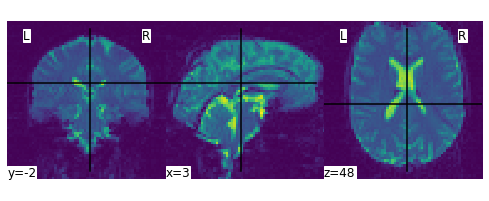

In [4]:
%matplotlib inline
plot_img(subject_data.func[0]);

***Exercise:***
in the next cell, please change the code so you display another than the first (in python this is counted as 0-th) image:

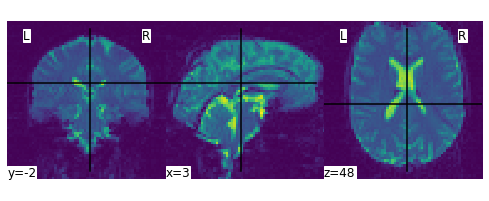

In [5]:
plot_img(subject_data.func[0]);

You can also display the subject's anatomical image:

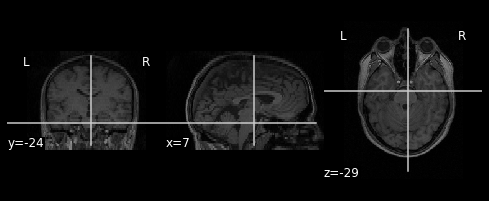

In [6]:
plot_anat(subject_data.anat);

Next, we concatenate all the "3D EPI images" (i.e. the functionals) into a single 4D image.

In [7]:
fmri_img = concat_imgs(subject_data.func)
print(fmri_img.shape)

(64, 64, 64, 96)


***Exercise:***
What does this output of the above cell actually mean? Explain to yourself by drawing and to your neighbor.

Let's plot the data from one voxel, that is retrieve the over-time activity series from one spot of the brain

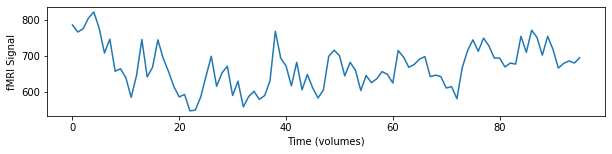

In [8]:
data_from_one_voxel = fmri_img.get_data()[22,30,26,:] #22,30,26
plt.figure(figsize = (10,2))
plt.plot(data_from_one_voxel);
plt.xlabel('Time (volumes)');
plt.ylabel('fMRI Signal');

***Exercise:***
Next, please try to insert a new empty cell below (so you also learn how to edit this notebook) 
Once you have successfully done that, copy the code for displaying one voxel's data into the new cell and play around by changing the voxel-coordinates. Try this multiple times. Can you find a particular wild voxel?

To show you how we can do math with these data, we can, for instance, average all the EPI images into one in order to create a background image that will be used to display the activations:

/Users/Ralf/anaconda3/lib/python3.7/site-packages/nilearn/image/image.py:455: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  not isinstance(imgs, collections.Iterable)):


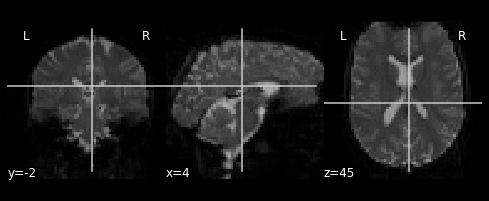

In [9]:
mean_img = image.mean_img(fmri_img)
plot_anat(mean_img);

Specifying the experimental paradigm
------------------------------------

Our goal is to actually analyze this single-person experiment (auditory stimuluation).

***Exercise:*** What do you expect to find? 

For the actual analysis, we must provide a description of the experiment, that is, define the timing of the auditory stimulation and rest periods. According to the documentation of the dataset, there were 16 42s blocks --- in
which 6 scans were acquired --- alternating between rest and auditory stimulation, starting with rest. We use standard python functions to create a pandas.DataFrame object that specifies the timings:

(you don't need to understand the details of this yet - just execute the code and try to get the gist)

In [10]:
tr = 7.
slice_time_ref = 0.
n_scans = 96
epoch_duration = 6 * tr  # duration in seconds
conditions = ['rest', 'active'] * 8
n_blocks = len(conditions)
duration = epoch_duration * np.ones(n_blocks)
onset = np.linspace(0, (n_blocks - 1) * epoch_duration, n_blocks)

events = pd.DataFrame({'onset': onset, 'duration': duration, 'trial_type': conditions})

The ``events`` object contains the information for the design:



In [11]:
print(events)

    onset  duration trial_type
0     0.0      42.0       rest
1    42.0      42.0     active
2    84.0      42.0       rest
3   126.0      42.0     active
4   168.0      42.0       rest
5   210.0      42.0     active
6   252.0      42.0       rest
7   294.0      42.0     active
8   336.0      42.0       rest
9   378.0      42.0     active
10  420.0      42.0       rest
11  462.0      42.0     active
12  504.0      42.0       rest
13  546.0      42.0     active
14  588.0      42.0       rest
15  630.0      42.0     active


***Exercise:*** What kind of design are we dealing with?

Performing the GLM analysis
---------------------------

We need to construct a *design matrix* using the timing information provided by the ``events`` object. The design matrix contains regressors of interest as well as regressors of non-interest modeling temporal drifts. 

With all these ingredients, we then create a ``FirstLevelModel`` object.

In [12]:
frame_times = np.linspace(0, (n_scans - 1) * tr, n_scans)
drift_model = 'Cosine'
period_cut = 4. * epoch_duration
hrf_model = 'glover + derivative'
fmri_glm = FirstLevelModel(tr, slice_time_ref, noise_model='ar1',
                           standardize=False, hrf_model=hrf_model,
                           drift_model=drift_model)# period_cut=period_cut) #not nice, but didn't work otherwise

Drumroll: Now, we fit the FirstLevelModel 'fmri_glm' to the data (4D dataset). Note that this is also called a mass-univariate analysis, that is we fit this model for each voxel individually, getting a beta-coefficient for each voxel. This is also why it takes a bit.

In [13]:
fmri_glm = fmri_glm.fit(fmri_img, events)

/Users/Ralf/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/Users/Ralf/anaconda3/lib/python3.7/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/Users/Ralf/anaconda3/lib/python3.7/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)


One can inspect the design matrix (rows represent time, and
columns contain the predictors):



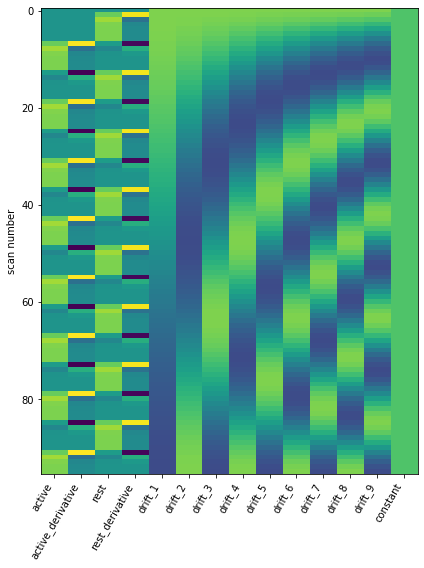

In [14]:
design_matrix = fmri_glm.design_matrices_[0]
fig, ax1 = plt.subplots(figsize=(6, 8), nrows=1, ncols=1)
plot_design_matrix(design_matrix, ax= ax1, rescale= True);

***Exercise:*** What does this matrix exactly mean? What are the critical columns that we care about in order to test our hypothesis? Hey, speaking of this, what's our hypthesis, actually? Explain to your neighbor or create new cell (change it so it is a comment cell) and write the answer in (it's better to be explicit about the hypothesis)!

The first column contains the expected reponse profile of regions which are
sensitive to the auditory stimulation. Let's grab that from the design matrix and plot it:

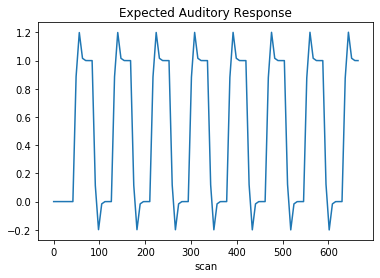

In [15]:
plt.plot(design_matrix['active'])
plt.xlabel('scan')
plt.title('Expected Auditory Response')
plt.show()

***Exercise:*** Bonus question: Why is this expected timecourse so oddly shaped and not just a on-off-pattern?

Detecting voxels with significant effects
-----------------------------------------

To access the estimated coefficients (Betas of the GLM model), we created constrasts with a single '1' in each of the columns.

(Again, you don't have to understand the details of the code, just try to follow the overall gist for now)



In [16]:
contrast_matrix = np.eye(design_matrix.shape[1])
contrasts = dict([(column, contrast_matrix[i])
                  for i, column in enumerate(design_matrix.columns)])

"""
contrasts::

  {
  'active':            array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  'active_derivative': array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  'constant':          array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
  'drift_1':           array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  'drift_2':           array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]),
  'drift_3':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]),
  'drift_4':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
  'drift_5':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]),
  'drift_6':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]),
  'drift_7':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]),
  'rest':              array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  'rest_derivative':   array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}
"""

"\ncontrasts::\n\n  {\n  'active':            array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),\n  'active_derivative': array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),\n  'constant':          array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),\n  'drift_1':           array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),\n  'drift_2':           array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]),\n  'drift_3':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]),\n  'drift_4':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),\n  'drift_5':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]),\n  'drift_6':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]),\n  'drift_7':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]),\n  'rest':              array([ 0.,  0.,  1.,  0

We can then compare the two conditions 'active' and 'rest' by
generating the relevant contrast that we can use to ~~ isolate ~~ the psychological process

(there are some tricky problems with this notion of process isolation and we're glossing over a lot of detail here, but for our purpose to localize brain regions associated with sound-stimulation this isn't so critical)



In [17]:
active_minus_rest =  contrasts['active'] - contrasts['rest']

eff_map = fmri_glm.compute_contrast(active_minus_rest,
                                    output_type='effect_size')

z_map = fmri_glm.compute_contrast(active_minus_rest,
                                  output_type='z_score')

Plot thresholded z scores map



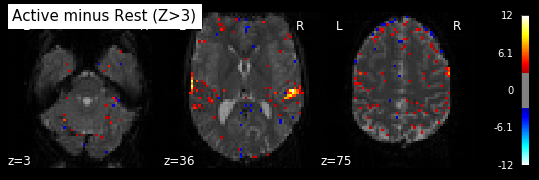

In [18]:
plot_stat_map(z_map, bg_img=mean_img, threshold=3.0,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (Z>3)');

***Exercise:*** Tada, what do you see? Where in the brain are we? What do you know about this territory? 

***Exercise:*** Below, you can also get a cooler view that you can surf in 3D. Try to do that and find whether there are other hotspots. 

In [19]:
plotting.view_img(z_map, bg_img=mean_img, threshold=3., title="Active vs. Rest contrast")  

/Users/Ralf/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


We can use ``nibabel.save`` to save the effect and zscore maps to the disk (Unfortunately, since we're running this in the cloud, you cannot get the data, but you could download the notebook, run the same code on your computer, and then you have it forever). 



In [20]:
outdir = 'results'
if not os.path.exists(outdir):
    os.mkdir(outdir)

nibabel.save(z_map, join('results', 'active_vs_rest_z_map.nii'))
nibabel.save(eff_map, join('results', 'active_vs_rest_eff_map.nii'))

/Users/Ralf/anaconda3/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Extract the signal from a voxels
 --------------------------------

We search for the voxel with the larger z-score and plot the signal
(warning: double dipping!)



In [21]:
# Find the coordinates of the peak
values = z_map.get_fdata()
coord_peaks = np.dstack(np.unravel_index(np.argsort(values.ravel()),
                                         values.shape))[0, 0, :]
coord_mm = apply_affine(z_map.affine, coord_peaks)

We create a masker for the voxel (allowing us to detrend the signal) and extract the time course.

(Again, no details needed here - we're just using a tool to extract from the large 4d-dataset the activity in a region around where we found something - this will then be put into the variable 'sig')

In [22]:
mask = NiftiSpheresMasker([coord_mm], radius=3,
                          detrend=True, standardize=True,
                          high_pass=None, low_pass=None, t_r=7.)
sig = mask.fit_transform(fmri_img)

/Users/Ralf/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


***Exercise:*** Create a new cell below, enter 'sig' and press enter. What does that mean?

Let's plot the signal and the theoretical response



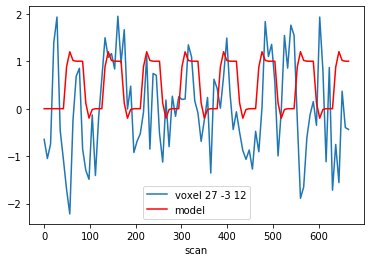

In [23]:
plt.plot(frame_times, sig, label='voxel %d %d %d' % tuple(coord_mm))
plt.plot(design_matrix['active'], color='red', label='model')
plt.xlabel('scan')
plt.legend()
plt.show()

***Exercise:*** What do you see? What does it mean? Why isn't the result perfect?

***Exercise:*** Congratulations, you have just completed a first analysis. Try to lean back and think about the steps you did! 
What would be the next steps?